In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import umap
import re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
import plotly.express as px


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedoc

/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv


In [2]:
pip install numba

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
import transformers


In [6]:
tqdm.pandas()

In [7]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install cleantext

Note: you may need to restart the kernel to use updated packages.


In [9]:
import cleantext
import contractions

In [10]:
data = pd.read_csv('/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv')
data.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [11]:
data.dropna(inplace= True)

<Axes: title={'center': 'number of values in each category'}>

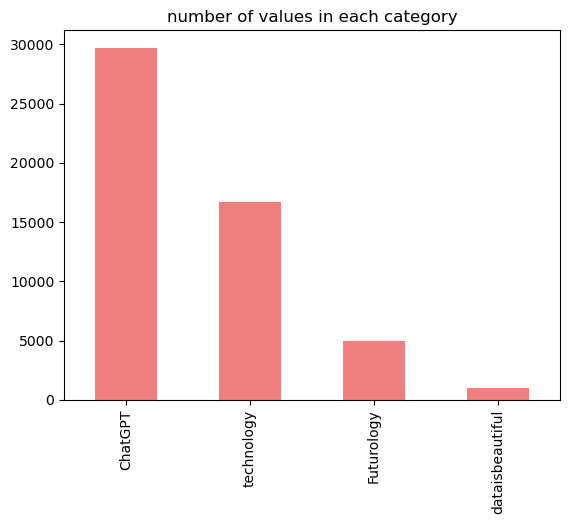

In [12]:
data['subreddit'].apply(lambda x: x.split('/')[1]).value_counts().plot.bar(color= 'lightcoral', title= 'number of values in each category')

In [13]:
data['comment_len'] = data['comment_body'].apply(lambda x : len(str(x).split(" ")))

In [14]:
data.describe()

,comment_len
count,52412.000000
mean,39.535946
std,61.936188
min,1.000000
25%,9.000000
50%,21.000000
75%,45.250000
max,1415.000000


# <span style="font-family:Times"><span style="font-size:1em">Cleaning Data</span>

In [15]:
#Fixes contractions such as `you're` to you `are`
data['comment_body_clean']= data['comment_body'].apply(lambda x: contractions.fix(x))

In [16]:
# remove urls
# data['comment_body_clean']= data['comment_body_clean'].apply(lambda x : re.sub("(http\S+)", "", x))
# remove email addresses
# data['comment_body_clean']= data['comment_body_clean'].apply(lambda x : re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", "", x))
# # Remove newline characters
# data['comment_body_clean']= data['comment_body_clean'].apply(lambda x : re.sub("(\n+)", "", x))

data['comment_body_clean']= data['comment_body_clean'].apply(lambda x : cleantext.clean(x, extra_spaces=True, stopwords= True, 
                                                            lowercase= True, punct= True, numbers=True, stp_lang='english',
                                                            reg=r'(http\S+)', reg_replace='', clean_all=False))

In [17]:
data['comment_body_clean'].replace('', np.nan, inplace=True)

In [18]:
data.dropna(subset = ['comment_body_clean'], inplace=True)

In [19]:
data['comment_len_clean'] = data['comment_body_clean'].apply(lambda x : len(str(x).split(" ")))

In [20]:
data

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,comment_len,comment_body_clean,comment_len_clean
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,10,shocked days need clickbait,4
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,229,angry right wasted time reading post sub click...,89
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,23,chatgpt karma whoring folks think stream thoug...,12
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,4,worked ngl,2
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,12,certified mustsee moment really shock core,6
...,...,...,...,...,...,...,...,...
52410,16667,j4lbiix,t1_j4kgcac,"Scary thing is, in this future text won’t be t...",r/technology,41,scary thing future text trustworthy either cas...,20
52411,16668,j5m0v6m,t3_10jmvpj,"Read the T.O.S., you'll thank me later",r/technology,7,read tos thank later,4
52412,16669,j5m6aj0,t1_j5m0v6m,What am I missing here... https://openai.com/t...,r/technology,6,missing,1
52413,16670,j5nylax,t1_j5m0v6m,What does ChatGTP think of its own TOS?,r/technology,8,chatgtp think tos,3


# <span style="font-family:Times"><span style="font-size:1em">Pre-Processing</span>

In [21]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case= True)
model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [22]:
data['tokens'] = data['comment_body_clean'].progress_apply(lambda x: np.array(tokenizer.encode(x, truncation=True)))

  0%|          | 0/51983 [00:00<?, ?it/s]

In [23]:
data['len_token'] = data['tokens'].apply(lambda x: len(x))

In [24]:
# removing data with fewer than 3 tokens 
df = data[data['len_token']>=3]

In [25]:
df.isnull().sum()

Unnamed: 0            0
comment_id            0
comment_parent_id     0
comment_body          0
subreddit             0
comment_len           0
comment_body_clean    0
comment_len_clean     0
tokens                0
len_token             0
dtype: int64

In [26]:
df

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,comment_len,comment_body_clean,comment_len_clean,tokens,len_token
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,10,shocked days need clickbait,4,"[101, 7135, 2420, 2342, 11562, 26068, 2102, 102]",8
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,229,angry right wasted time reading post sub click...,89,"[101, 4854, 2157, 13842, 2051, 3752, 2695, 494...",113
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,23,chatgpt karma whoring folks think stream thoug...,12,"[101, 11834, 21600, 2102, 19902, 2040, 4892, 1...",17
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,4,worked ngl,2,"[101, 2499, 12835, 2140, 102]",5
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,12,certified mustsee moment really shock core,6,"[101, 7378, 2442, 19763, 2617, 2428, 5213, 456...",9
...,...,...,...,...,...,...,...,...,...,...
52410,16667,j4lbiix,t1_j4kgcac,"Scary thing is, in this future text won’t be t...",r/technology,41,scary thing future text trustworthy either cas...,20,"[101, 12459, 2518, 2925, 3793, 3404, 13966, 25...",26
52411,16668,j5m0v6m,t3_10jmvpj,"Read the T.O.S., you'll thank me later",r/technology,7,read tos thank later,4,"[101, 3191, 2000, 2015, 4067, 2101, 102]",7
52412,16669,j5m6aj0,t1_j5m0v6m,What am I missing here... https://openai.com/t...,r/technology,6,missing,1,"[101, 4394, 102]",3
52413,16670,j5nylax,t1_j5m0v6m,What does ChatGTP think of its own TOS?,r/technology,8,chatgtp think tos,3,"[101, 11834, 13512, 2361, 2228, 2000, 2015, 102]",8


In [27]:
# Selecting 20% of the data for KMeans training while maintaining the original category proportions
train_data, test_data, train_labels, test_labels = train_test_split(df, df['subreddit'], test_size=0.8, stratify=df['subreddit'])

<Axes: title={'center': 'number of values in each category'}>

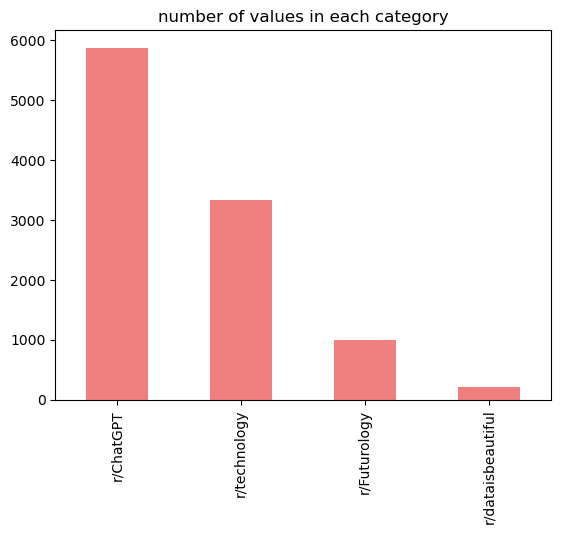

In [28]:
train_data['subreddit'].value_counts().plot.bar(color= 'lightcoral', title= 'number of values in each category')

In [29]:
len(train_data)

10396

In [30]:
# embedding data based on pre-trained Bert model
train_data['embedd'] = train_data['tokens'].progress_apply(lambda x: np.array(model(x[None,:])[0][0][1:-1]).mean(0))

  0%|          | 0/10396 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
features_bert = pd.DataFrame(train_data['embedd'].tolist())

# <span style="font-family:Times"><span style="font-size:1em">determine the optimal number of clusters for KMeans</span>

> <span style="font-family:Times"><span style="font-size:1.3em">Elbow Method</span>

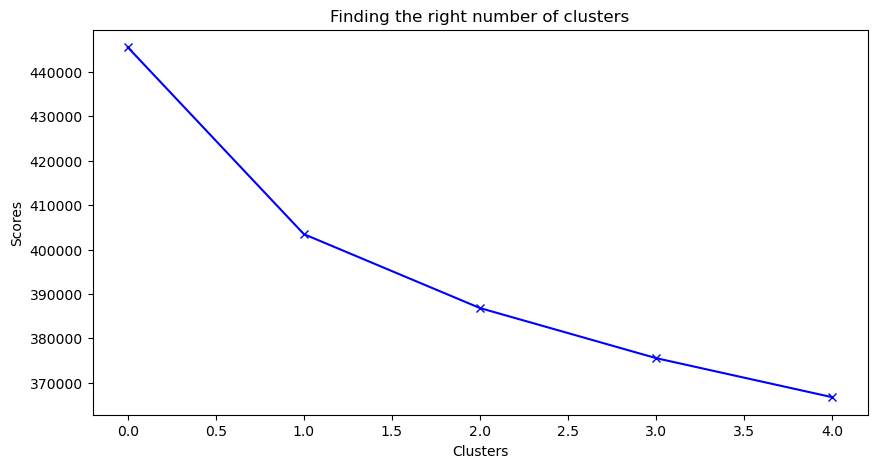

In [32]:
scores_1 = []

range_values = range(1, 6)

for i in range_values:
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0,)
  kmeans.fit(features_bert)
  scores_1.append(kmeans.inertia_) 
plt.figure(figsize = (10,5))
plt.plot(scores_1, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

> <span style="font-family:Times"><span style="font-size:1.3em">silhouette score</span>

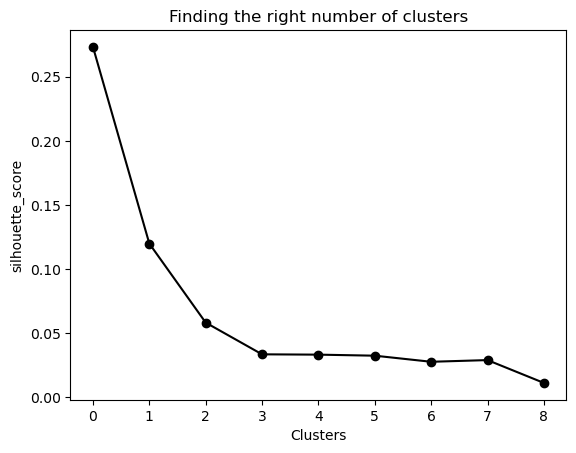

In [33]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(features_bert)
  labels = kmeans.labels_
  sil.append(metrics.silhouette_score(features_bert, labels, metric = 'euclidean'))
plt.plot(sil, marker='o', linestyle='-', color='black')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('silhouette_score') 
plt.show()

<span style="font-family:Times"><span style="font-weight: bold"><span style="color:green"><span style="font-size:1.5em"> Based on silhouette score plot, 3 clusters might be a good choice for this dataset.</span>

# <span style="font-family:Times"><span style="font-weight: bold"><span style="color:white"><span style="font-size:1.5em"> Kmeans clustring</span>

<span style="font-family:Times"><span style="font-weight: 40"><span style="line-height:2"><span style="font-size:1.4em"> <span>We will first define our evaluation benchmark. During this benchmark, we intend to compare different vector representaion method for our text data like BoW(TF-IDF) and Transformer-Based Models(Bert) for KMeans clusting. Our benchmark will measure the performance of the clustering obtained via different metrics:<br>1-Inertia<br>2-Davies-Bouldin<br>span>3-Calinski-Harabasz<br>4-Silhouette Coefficient<br>we will also comapre the performance of kmeans when using PCA and UMAP method for dimentionality reduction for our Bert features. In other method, we will use the components of the PCA to initialize KMeans for Bert features.
</span>

In [34]:
evaluations = []
fig_list = []


def fit_and_evaluate(km, X, X_plot, name):

    scores = {}
    km.set_params(random_state=0)
    colors = ['red', 'green', 'blue']
    t0 = time()
    estimator = km.fit(X)
    labels = estimator.labels_
    train_times = time() - t0
    scores["Inertia"]=(estimator.inertia_)
    scores["Davies-Bouldin"]=(metrics.davies_bouldin_score(X, labels))
    scores["Calinski-Harabasz"]=(metrics.calinski_harabasz_score(X, labels))
    scores["Silhouette Coefficient"]=(metrics.silhouette_score(X, labels))

    print(f"clustering done in {train_times:.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times
    }
    for score_name, score_values in scores.items():
        print(f"{score_name}: {score_values:.3f}")
        evaluation[score_name] = score_values
    evaluations.append(evaluation)
    
    fig = px.scatter(x=X_plot[:,0], y=X_plot[:,1], color=estimator.labels_, color_discrete_sequence=colors)
    fig.update_layout(xaxis_title='dim1', yaxis_title='dim2',title= name)

    fig_list.append(fig)


> <span style="font-family:Times"><span style="font-size:2em">clustring with TF-IDF features</span>

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5, max_df=0.5)
X_tfidf = vectorizer.fit_transform(train_data['comment_body_clean'])

#Initialize Kmeans:
km_tfidf = KMeans(init= "k-means++" , n_clusters=3, n_init=10)

# Visualize the results on tsvd-reduced tf-idf features
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)


fit_and_evaluate(km_tfidf, X_tfidf.toarray(), X_lsa, name="KMeans\nk-means++\non tf-idf vectors")

clustering done in 19.78 s 
Inertia: 9910.287
Davies-Bouldin: 6.671
Calinski-Harabasz: 90.311
Silhouette Coefficient: 0.020


> <span style="font-family:Times"><span style="font-size:2em">clustring on tsvd-reduced TF-IDF features</span>

In [36]:
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

km_tfidf_lsa = KMeans(n_clusters=3, init= "k-means++", n_init=10)

fit_and_evaluate(km_tfidf_lsa, X_lsa, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

Explained variance of the SVD step: 21.7%
clustering done in 1.95 s 
Inertia: 9241.526
Davies-Bouldin: 3.961
Calinski-Harabasz: 214.620
Silhouette Coefficient: 0.023


> <span style="font-family:Times"><span style="font-size:2em">clustring on Bert features</span>

In [37]:
pca = PCA(n_components=100).fit(features_bert.to_numpy())
reduced_data = pca.transform(features_bert.to_numpy())

#Initialize Kmeans:
kmeans_Bert = KMeans(init="k-means++", n_clusters=3, n_init=10)

fit_and_evaluate(kmeans_Bert, features_bert.to_numpy(), reduced_data, name="KMeans\non Bert features")


clustering done in 5.19 s 
Inertia: 386807.625
Davies-Bouldin: 3.335
Calinski-Harabasz: 789.395
Silhouette Coefficient: 0.120


> <span style="font-family:Times"><span style="font-size:2em">clustring on pca-reduced Bert features</span>

In [38]:
explained_variance_pca = pca.explained_variance_ratio_.sum()
print(f"Explained variance of the pca step: {explained_variance_pca * 100:.1f}%")

kmeans_Bert_pca = KMeans(init="k-means++", n_clusters=3, n_init=10)

fit_and_evaluate(kmeans_Bert_pca, reduced_data, reduced_data, name="KMeans\nwith pca\non Bert features")


Explained variance of the pca step: 77.3%
clustering done in 2.06 s 
Inertia: 285784.250
Davies-Bouldin: 2.853
Calinski-Harabasz: 1067.888
Silhouette Coefficient: 0.127


> <span style="font-family:Times"><span style="font-size:2em">clustring with pca-reduced on Bert features using pca initialization</span>

In [39]:
n_clusters = 3
n_features = 100

#Initialize Kmeans:
kmeans_bert_initpca = KMeans(init=pca.components_[:n_clusters,:n_features], n_clusters=n_clusters, n_init=1)

fit_and_evaluate(kmeans_bert_initpca, reduced_data, reduced_data, name="KMeans\nwith pca\non Bert features\nwith pca init")


clustering done in 0.05 s 
Inertia: 285785.062
Davies-Bouldin: 2.855
Calinski-Harabasz: 1067.873
Silhouette Coefficient: 0.126


> <span style="font-family:Times"><span style="font-size:2em">clustring on umap-reduced on Bert features</span>

In [40]:
# reduce bert features dimention using UMAP method  
um = umap.UMAP()  
reduced_data_um = um.fit_transform(features_bert.to_numpy())

# initialize kmeans
kmeans_bert_um = KMeans(init="k-means++", n_clusters=3, n_init=10)

fit_and_evaluate(kmeans_bert_um, reduced_data_um, reduced_data_um, name="KMeans\nwith umap\non Bert features")

clustering done in 0.07 s 
Inertia: 44914.398
Davies-Bouldin: 0.697
Calinski-Harabasz: 7530.029
Silhouette Coefficient: 0.422


# <span style="font-family:Times"><span style="font-size:2em">compare results</span>

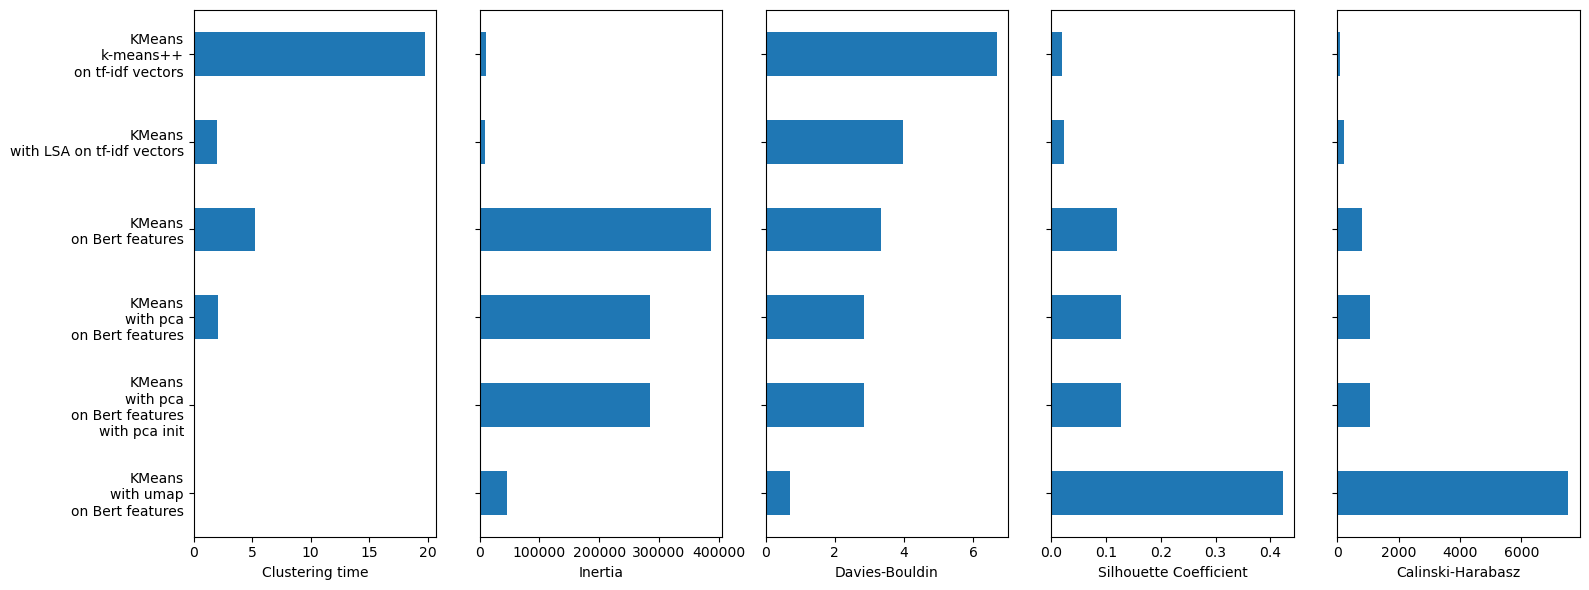

In [41]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(16, 6) , sharey=True)

df_scores = pd.DataFrame(evaluations[::-1]).set_index("estimator")

df_scores["train_time"].plot.barh(ax=axs[0])
axs[0].set_xlabel("Clustering time")
axs[0].set_ylabel("")

df_scores["Inertia"].plot.barh(ax=axs[1])
axs[1].set_xlabel("Inertia")
df_scores["Davies-Bouldin"].plot.barh(ax=axs[2])
axs[2].set_xlabel("Davies-Bouldin")
df_scores["Silhouette Coefficient"].plot.barh(ax=axs[3])
axs[3].set_xlabel("Silhouette Coefficient")
df_scores["Calinski-Harabasz"].plot.barh(ax=axs[4])
axs[4].set_xlabel("Calinski-Harabasz")

for i in range(len(fig_list)):
   fig_list[i].show()
plt.tight_layout()
